<a href="https://colab.research.google.com/github/laksjdjf/sd-trainer/blob/main/sd_trainer_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

このノートブックおよび元のリポジトリは、[waifu-diffusion](https://github.com/harubaru/waifu-diffusion)ならびに[sd-scripts](https://github.com/kohya-ss/sd-scripts)から非常に多くの着想を得て（つまりぱくって）作られています。両リポジトリの作者であるharu氏とkohya-ss氏に感謝いたします。

じゃあ何がこの2つと違うんだよ、というと2つのリポジトリは様々な機能を逐次実装しているため、コードの規模がどんどん大きく複雑になっています。この訓練コードは私が個人的に欲しい機能のみに絞って、自由度を下げることにより単純に使えるようにしたものです。（なくした機能例：複数GPUによる並列計算、xformersが使えない環境でのメモリ効率化方法、DreamboothやHypernetworkへの対応、ckpt⇔diffusers等）

自由度が高いと便利ですが、初めて学習してみる人には訳が分からない設定項目が増えていって大変です。このノートブックはそうしためんどくさい設定はおいておいて、データセットの場所と保存先さえ指定してくれたらとりあえず動くぞ！（結果はどうなるか分からないが）という感じです。また自分が使うような設定でしかテストしていないので、他の設定をするとどんなことが起こるかよく分かりません。

**初めて学習してみる人のため、とか言っておきながらPythonやlinuxのCUIに慣れていない人が動かすことは想定していません。またdiffusersをckptにしたりwebuiで使う方法といったものはありません。**

# AspectDatasetによる学習

学習用画像（hoge.png, piyo.jpg, ...）とその説明文(hoge.caption, piyo.caption, ...)がドライブに必要です(pngしか確認していないのでpng推奨)。説明文用意するには[これ](https://github.com/toriato/stable-diffusion-webui-wd14-tagger)使えばいいんじゃないかな。

コードを非表示にして、決められた枠に設定項目うちこんで何も考えずに再生ボタンを押してください見たいなやつきらいなのでやりません。

NVIDIA T4でテストしています。

In [1]:
!nvidia-smi

Wed Jan 25 05:39:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 環境構築等

ドライブのマウントを前提とする。

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


※※ドライブ直下にリポジトリがダウンロードされます。

In [ ]:
!git clone https://github.com/laksjdjf/sd-trainer.git

Cloning into 'sd-trainer'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 126 (delta 56), reused 19 (delta 7), pack-reused 0
Receiving objects: 100% (126/126), 54.06 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [4]:
%cd /content/drive/MyDrive/sd-trainer/

/content/drive/MyDrive/sd-trainer


In [10]:
#!git pull origin main #update用

In [5]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 930.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 

xformersのインストール、T4以外でうまくいくか分からない。A100だとだめでした。

In [6]:
#インストールコマンドはhttps://github.com/Linaqruf/kohya-trainerから持ってきました
!pip -qqqq install -U -I --no-deps https://github.com/camenduru/stable-diffusion-webui-colab/releases/download/0.0.15/xformers-0.0.15.dev0+189828c.d20221207-cp38-cp38-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 MB 9.3 MB/s eta 0:00:00


hugging faceのログインが必要なモデルを使う場合はログインする。（Waifu Diffusionならいらない）

In [ ]:
from huggingface_hub import login
login()

# 前処理

画像を[Aspect ratio bucketing](https://github.com/NovelAI/novelai-aspect-ratio-bucketing)により前処理します。引数は良い感じに変えてくださいね（特にデータセットの場所と保存先）。解像度はColabの無料版に合わせて下げておきます。Pro+のA100とかでぶん回したい人はデフォルトの設定（コマンドライン引数を指定しないときの値）でいいと思います。

詳しい説明

Aspect ratio bucketingはNovelAIが考えた学習手法です。Stable Diffusionのモデルは64の倍数であれば、どんな解像度にも（結果はどうあれ）対応できるのですが、複数の画像を並列計算する場合は解像度を合わせなければいけません。そこで、まずいくつかの解像度候補（bucket）を選び、学習画像を一番近いアスペクト比のbucketにリサイズします。そして学習する際は同じbucketのデータを取り出すようにします。これにより複数のアスペクト比を持つデータセットに対応できるようになります。

--resolutionは正方形bucketの解像度であり、全てのbucketそのピクセル数を越えないように作られます。

--min_lengthはbucketの最小長です。maxの方は同様

--max_ratioはアスペクト比最大値（逆数が最小値）になります。この範囲を越えるbucketは作らず、極端なアスペクト比の画像は学習用データセットから取り除かれます。

In [7]:
!python preprocess/bucketing.py \
--input_dir "../dataset" \
--output_dir "../dataset_preprocess" \
--resolution 512 \
--min_length 256 \
--max_length 768 \
--max_ratio 2.5 

[[320 768]
 [320 704]
 [384 640]
 [448 576]
 [512 512]
 [576 448]
 [640 384]
 [704 320]
 [768 320]]
100% 251/251 [01:28<00:00,  2.83it/s]
(448, 576): 157個
(384, 640): 23個
(512, 512): 13個
(576, 448): 32個
(640, 384): 13個
(320, 768): 9個
(320, 704): 4個


アニメイラストだったらだいたい幅：高さが0.7:1くらいの解像度が一番多いと思います。

画像をVAEにより潜在変数にします。あらかじめ計算をやっておくことで、2エポック以上なら学習が早くなります。モデルは学習対象を選んだ方が確実ですが、別のモデルでも割と問題なさそうです。

In [ ]:
!python preprocess/latent.py \
--directory ../dataset_preprocess/ \
--output_path ../dataset_preprocess/ \
--model "hakurei/waifu-diffusion" \
--batch_size 4

Downloading: 100% 335M/335M [00:03<00:00, 86.8MB/s]
Downloading: 100% 601/601 [00:00<00:00, 465kB/s]
(448, 576)
100% 157/157 [00:22<00:00,  6.92it/s]
(384, 640)
100% 23/23 [00:02<00:00, 11.41it/s]
(512, 512)
100% 13/13 [00:01<00:00, 10.39it/s]
(576, 448)
100% 32/32 [00:03<00:00,  9.55it/s]
(640, 384)
100% 13/13 [00:01<00:00, 10.96it/s]
(320, 768)
100% 9/9 [00:00<00:00, 11.38it/s]
(320, 704)
100% 4/4 [00:00<00:00, 10.70it/s]


説明文ファイル(hoge.caption)を前処理した潜在変数がある場所と同じ場所に置く。
最終的には、

```
dataset_preprocess/
            |ーbuckets.json (bucketing.pyで作られるメタデータ)
            |ーhoge.npy
            |ーhoge.caption
            |ーpiyo.npy
            |ーpiyo.caption
            ・
            ・
```

みたいになってればおｋ（npy,caption以外に無駄ファイルがあってもおｋ）



In [ ]:
#これをするかどうかは人によると思います。.txtで説明文を持っている場合はよくわからないけどlinux 拡張子 一括変更とかで検索してください。
#!cp ../dataset/*.caption ../dataset_preprocess/

In [ ]:
#!ls ../dataset_preprocess #確認用

## 訓練するぞ！訓練するぞ！訓練するぞ！徹底的に訓練するぞ！

モデル、データセットの場所等を適切に選んでください。

--outputで指定したディレクトリ名で保存されます。（loraの場合は--output.pt)

--image_log 検証画像の保存先です。

--resolutionは今回の場合検証画像の生成解像度になります（訓練には影響しない）。

--loraは0にするとlora無しになります。nを指定するとrankがnのloraを学習します。負の数を入れたら何が起きるか分かりません。

--lrはloraだったら1e-4(rank=128みたいな大きい値だったら1e-3)、loraなしだったら5e-6、1e-5あたりを推奨します。

--wandb Weight&BiasというWebアプリで学習の様子が記録できます。使う場合はアカウントを作ってAPI keyを発行してください。

--v_prediction SD2系(baseがつかないやつ)を学習させる場合は設定してください

デフォルトの設定では、VRAM使用量10.5GBでした。**検証画像の生成時にVRAM使用量が上がるので注意してください。**RAMも標準だと7割くらい使っててかなり危ないラインですね。

**このコードのloraはkohya-ss氏の実装とすこ～しだけ違います。そのためこのリポジトリで作成したloraが使えなかった場合、まず私のリポジトリで教えてください。**

In [ ]:
#コマンドで実行するとプログレスバーがバグるの何とかする方法教えてください。
!python3 main.py \
--model "hakurei/waifu-diffusion" \
--dataset "../dataset_preprocess" \
--output "wd14_colab" \
--image_log "image_logs" \
--resolution "512,512" \
--batch_size 2 \
--lr "1e-4" \
--epochs 20 \
--save_n_epochs 4 \
--amp \
--lora 16 \
--use_bucket 

# 学習したモデルを試してみる

一応生成用スクリプトも入れておきますが、基本的にはwebuiで使うことを前提にしています。

ckptにしたい場合⇒[convert_diffusers20_original_sd.py](https://github.com/kohya-ss/sd-scripts/blob/main/tools/convert_diffusers20_original_sd.py)

loraを使いたい場合⇒[sd-webui-additional-networks](https://github.com/kohya-ss/sd-webui-additional-networks)

**このコードのloraはkohya-ss氏の実装とすこ～しだけ違います。そのためこのリポジトリで作成したloraが使えなかった場合、まず私のリポジトリで教えてください。**

In [11]:
from diffusers import StableDiffusionPipeline
import torch

model_path = "hakurei/waifu-diffusion" #loraを使わなかった場合ここを学習したモデルにする
lora_path = "wd14_colab.pt" #loraの場合ここに.ptのパス
use_lora = True #使う場合True
lora_rank = 16 #rank

pipe = StableDiffusionPipeline.from_pretrained(model_path,safety_checker=None, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

#学習用のlora適用を無理やり実装しているだけで、マジの生成でこれをやるのはお勧めしない。
if use_lora:
    from lora.lora import LoRANetwork
    network = LoRANetwork(None, pipe.unet,lora_rank)
    network.requires_grad_(False)
    network.load_state_dict(torch.load(lora_path))
    network.to("cuda",torch.float16)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


create LoRA for U-Net: 192 modules.


  0%|          | 0/50 [00:00<?, ?it/s]

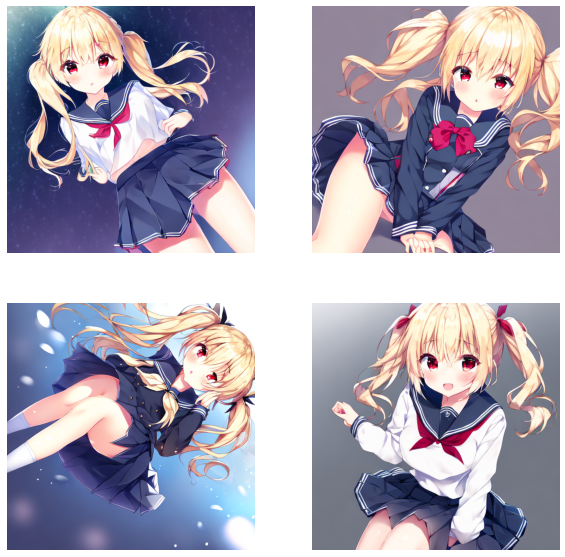

In [20]:
import matplotlib.pyplot as plt
prompt = "masterpiece,best quality,1girl,solo,blonde hair,twintails,red eyes,blush,school uniform" #金髪ツインテは正義
negative_prompt = "worst quality, low quality, medium quality, deleted, lowres, comic, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, blurry"

generator = torch.Generator("cuda").manual_seed(4545) #これにより、なんどやっても同じ画像になります。いらない場合は下のgeneratorの指定を消しましょう。
images = pipe([prompt]*4, height=512, width=512,negative_prompt=[negative_prompt]*4,num_inference_steps=50,guidance_scale=7.5,generator=generator)[0]

plt.figure(figsize=(10,10))
for i,image in enumerate(images):
    plt.subplot(2,2,i+1)
    plt.imshow(image)
    plt.axis('off')